In [ ]:
import pennylane as qml
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from typing import Tuple, Dict, Any
import logging
from dataclasses import dataclass

# Configure logging for better visibility into the process
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class ModelConfig:
    """Configuration settings for our quantum-classical hybrid model"""
    n_qubits: int           # Number of qubits in quantum circuit
    n_layers: int           # Number of layers in quantum circuit
    learning_rate: float = 0.01
    batch_size: int = 32
    epochs: int = 100
    early_stopping_patience: int = 10

In [ ]:
class DataPreprocessor:
    """
    Handles data preprocessing for credit risk analysis, including:
    - Missing value imputation
    - Feature scaling
    - Categorical encoding
    - Dimensionality reduction
    """
    def __init__(self, max_features: int = None, n_neighbors: int = 5):
        self.max_features = max_features
        self.n_neighbors = n_neighbors
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.imputer = KNNImputer(n_neighbors=n_neighbors)
        self.pca = None

        # Column information
        self.numerical_columns = [
            'person_age', 'person_income', 'person_emp_length',
            'loan_amnt', 'loan_int_rate', 'loan_percent_income'
        ]
        self.categorical_columns = [
            'person_home_ownership', 'loan_intent', 'loan_grade'
        ]

    def fit_transform(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """Complete preprocessing pipeline with careful type handling"""
        logger.info("Starting preprocessing pipeline...")

        # Extract target variable
        y = df['loan_status'].values

        # Handle missing values and convert types
        X_clean = self._handle_missing_values(df)

        # Scale numerical features
        X_scaled = self._scale_features(X_clean)

        # Convert to correct dtype
        X_final = X_scaled.astype(np.float32)
        y = y.astype(np.float32)

        logger.info(f"Final feature shape: {X_final.shape}")
        return X_final, y

    def _handle_missing_values(self, df: pd.DataFrame) -> np.ndarray:
        """Handle missing values with appropriate strategies for each column type"""
        # Separate numerical and categorical data
        df_num = df[self.numerical_columns].copy()
        df_cat = df[self.categorical_columns].copy()

        # Handle numerical missing values
        df_num = pd.DataFrame(
            self.imputer.fit_transform(df_num),
            columns=df_num.columns,
            index=df_num.index
        )

        # Handle categorical missing values
        for col in self.categorical_columns:
            df_cat[col] = df_cat[col].fillna('Missing')
            self.label_encoders[col] = LabelEncoder()
            df_cat[col] = self.label_encoders[col].fit_transform(df_cat[col])

        # Combine processed features
        return pd.concat([df_num, df_cat], axis=1).values

    def _scale_features(self, X: np.ndarray) -> np.ndarray:
        """Scale features and apply dimensionality reduction if needed"""
        X_scaled = self.scaler.fit_transform(X)

        if self.max_features and X_scaled.shape[1] > self.max_features:
            self.pca = PCA(n_components=self.max_features)
            X_scaled = self.pca.fit_transform(X_scaled)
            logger.info(f"Reduced dimensions to {X_scaled.shape[1]} features")

        return X_scaled

In [ ]:
class QuantumCircuit:
    """
    Implements the quantum part of our hybrid model.
    Uses PennyLane for quantum circuit simulation.
    """
    def __init__(self, n_qubits: int, n_layers: int):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qnode = qml.QNode(self.circuit, self.dev)

        # Initialize quantum circuit parameters
        self.weights = {
            "weights_rx": np.random.uniform(0, 2*np.pi, size=(n_layers, n_qubits)),
            "weights_ry": np.random.uniform(0, 2*np.pi, size=(n_layers, n_qubits)),
            "weights_rz": np.random.uniform(0, 2*np.pi, size=(n_layers, n_qubits)),
            "weights_final": np.random.uniform(0, 2*np.pi, size=n_qubits)
        }

        # Convert weights to float32
        for k in self.weights:
            self.weights[k] = self.weights[k].astype(np.float32)

    def circuit(self, inputs: np.ndarray, **weights):
        """Define quantum circuit architecture"""
        # Data embedding
        inputs = inputs.astype(np.float32)
        qml.templates.AmplitudeEmbedding(
            inputs / np.linalg.norm(inputs),
            wires=range(self.n_qubits),
            normalize=True,
            pad_with=0.0
        )

        # Apply quantum layers
        for layer in range(self.n_layers):
            # Rotation gates
            for qubit in range(self.n_qubits):
                qml.RX(weights["weights_rx"][layer, qubit], wires=qubit)
                qml.RY(weights["weights_ry"][layer, qubit], wires=qubit)
                qml.RZ(weights["weights_rz"][layer, qubit], wires=qubit)

            # Entanglement
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[self.n_qubits - 1, 0])

        # Final rotation layer
        for qubit in range(self.n_qubits):
            qml.RX(weights["weights_final"][qubit], wires=qubit)

        # Measurements
        return [qml.expval(qml.PauliZ(i)) for i in range(self.n_qubits)]

In [ ]:
def train_credit_risk_model(data_path: str, config: ModelConfig):
    """Complete training pipeline for credit risk analysis"""
    # Load and preprocess data
    df = pd.read_csv(data_path)
    preprocessor = DataPreprocessor(max_features=2**config.n_qubits)
    X_processed, y = preprocessor.fit_transform(df)

    print(f"Input feature dimension: {X_processed.shape[1]}")
    print(f"Quantum circuit qubits: {config.n_qubits}")
    print(f"Pre-quantum dimension: {2**config.n_qubits}")

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_processed, y, test_size=0.3, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    # Create and train model
    model = HybridModel(input_size=X_processed.shape[1], config=config)
    trainer = ModelTrainer(model, config)

    # Train model
    history = trainer.train(X_train, y_train, X_val, y_val)

    return model, history, (X_test, y_test)

# Example usage
config = ModelConfig(
    n_qubits=6,
    n_layers=2,
    learning_rate=0.01,
    epochs=100,
    early_stopping_patience=10
)

model, history, test_data = train_credit_risk_model("credit_risk_dataset.csv", config)

INFO:__main__:Starting preprocessing pipeline...
INFO:__main__:Final feature shape: (32581, 9)
INFO:__main__:Epoch 0: Train Loss = 0.5041, Val Loss = 0.4750
INFO:__main__:Epoch 10: Train Loss = 0.4511, Val Loss = 0.4596
INFO:__main__:Epoch 20: Train Loss = 0.4511, Val Loss = 0.4594
INFO:__main__:Early stopping triggered at epoch 24


In [ ]:
history.keys()

dict_keys(['train_losses', 'val_losses'])

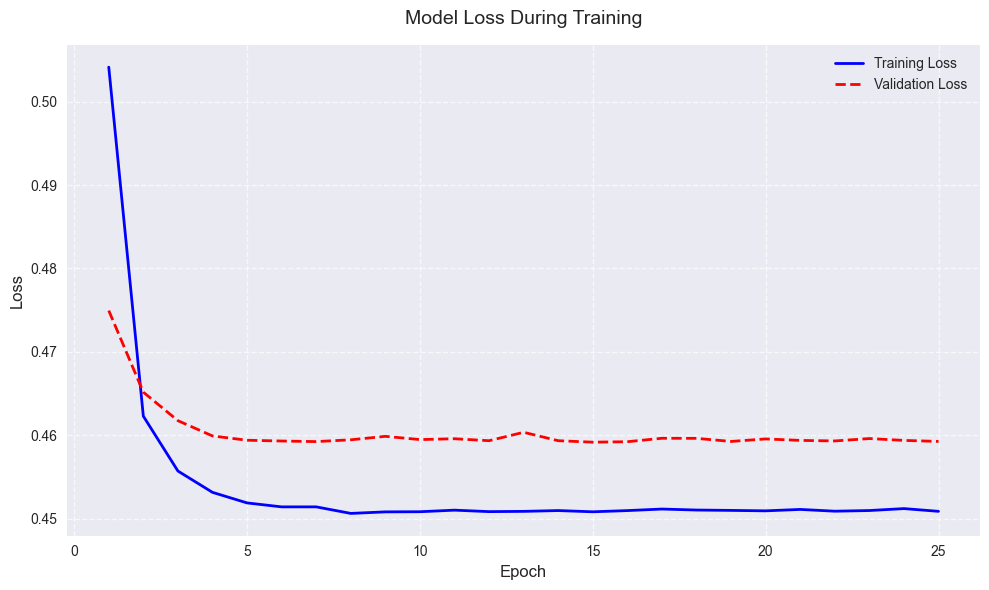


Training Summary:
Initial training loss: 0.5041
Final training loss: 0.4509
Best training loss: 0.4507

Initial validation loss: 0.4750
Final validation loss: 0.4593
Best validation loss: 0.4592

Best validation loss occurred at epoch 15


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    # Create a figure with a specific size for better readability
    plt.figure(figsize=(10, 6))

    # Get the number of epochs from the length of loss arrays
    epochs = range(1, len(history['train_losses']) + 1)

    # Plot both training and validation losses
    plt.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_losses'], 'r--', label='Validation Loss', linewidth=2)

    # Customize the plot with informative labels and title
    plt.title('Model Loss During Training', fontsize=14, pad=15)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Ensure the plot layout is optimized
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print summary statistics for additional insight
    print("\nTraining Summary:")
    print(f"Initial training loss: {history['train_losses'][0]:.4f}")
    print(f"Final training loss: {history['train_losses'][-1]:.4f}")
    print(f"Best training loss: {min(history['train_losses']):.4f}")
    print(f"\nInitial validation loss: {history['val_losses'][0]:.4f}")
    print(f"Final validation loss: {history['val_losses'][-1]:.4f}")
    print(f"Best validation loss: {min(history['val_losses']):.4f}")

    # Calculate and print the epoch with the best validation loss
    best_epoch = np.argmin(history['val_losses']) + 1
    print(f"\nBest validation loss occurred at epoch {best_epoch}")

# Use the function with your training history
plot_training_history(history)

/var/folders/dp/0s_jjpzn3hn44cft710n9x0h0000gn/T/ipykernel_41101/3461534695.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


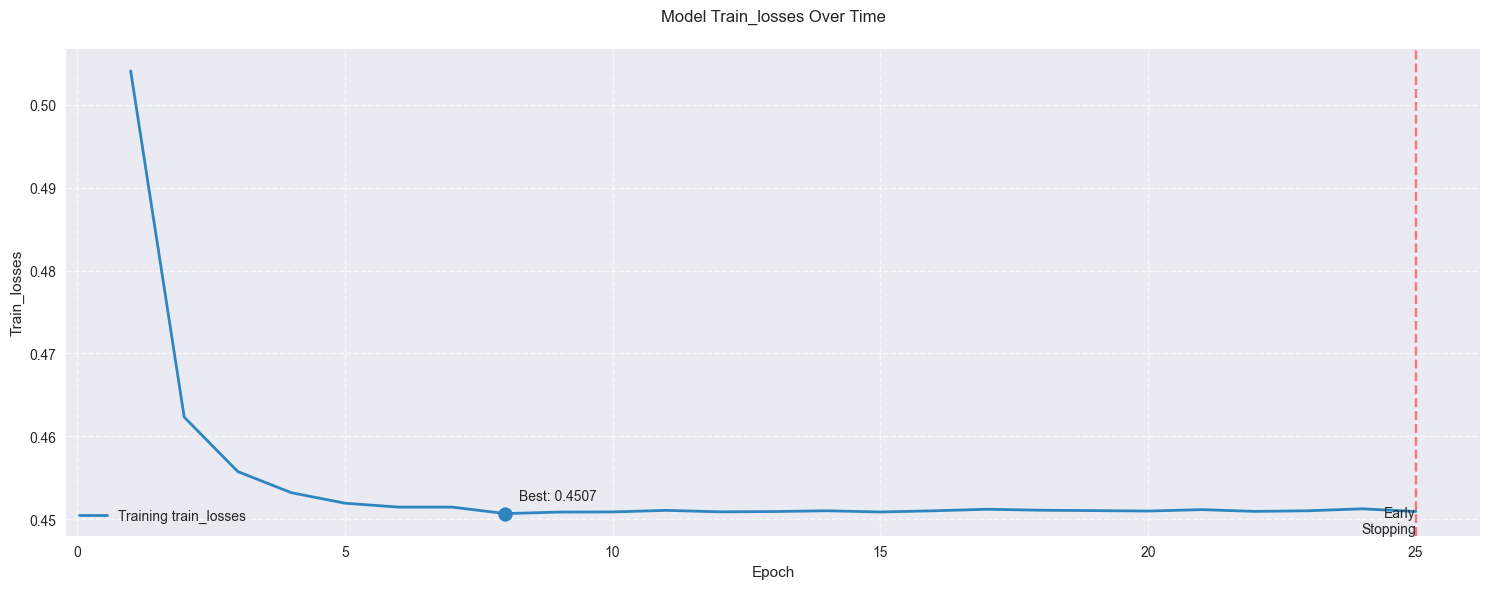

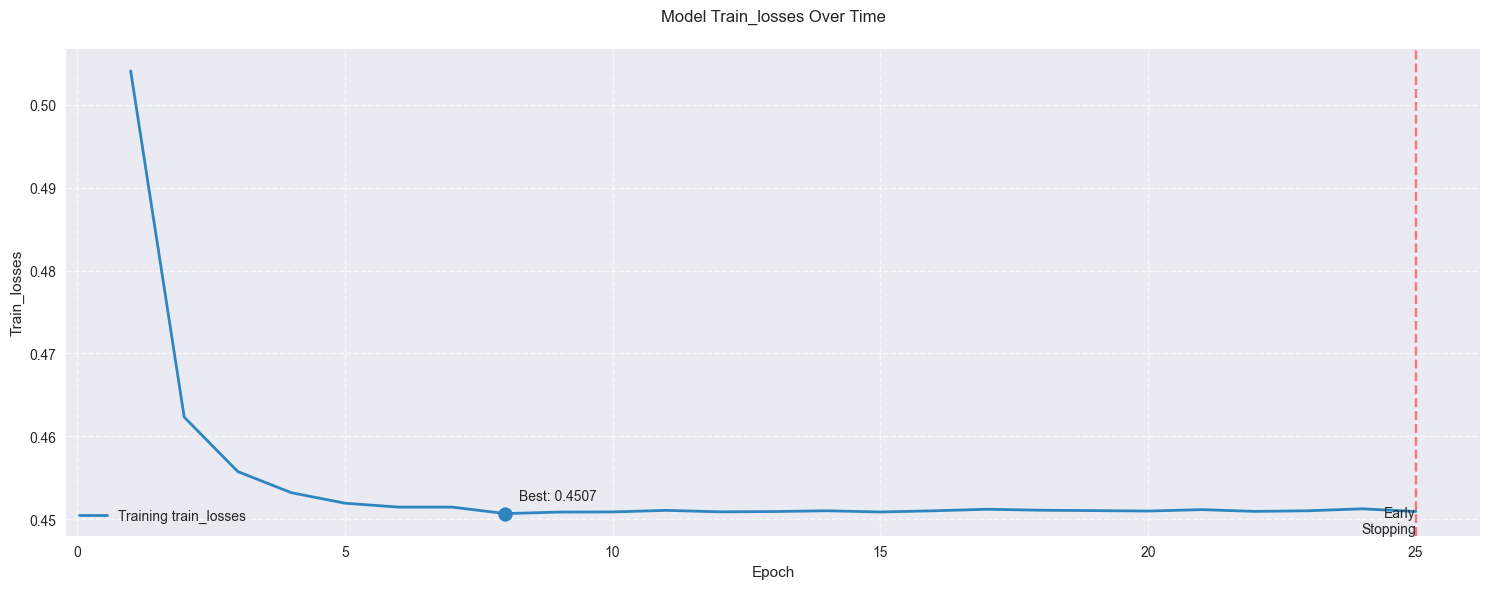

In [ ]:
plot_training_history(history, figsize=(15, 6))

In [ ]:
class ModelEvaluator:
    """
    Evaluates the performance of a trained quantum-classical hybrid model for credit risk prediction.
    Provides detailed metrics and visualizations to understand model performance.
    """
    def __init__(self, model: HybridModel, preprocessor: DataPreprocessor):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.preprocessor = preprocessor

    def evaluate_model(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """
        Evaluates model performance using multiple metrics.

        Args:
            X_test: Test features
            y_test: True labels

        Returns:
            Dictionary containing various performance metrics
        """
        # Convert data to tensors
        X_tensor = torch.tensor(X_test, dtype=torch.float32)

        # Get predictions
        with torch.no_grad():
            outputs = self.model(X_tensor)
            probabilities = outputs.numpy().flatten()
            predictions = (probabilities >= 0.5).astype(int)

        # Calculate metrics
        metrics = {
            'accuracy': np.mean(predictions == y_test),
            'precision': precision_score(y_test, predictions),
            'recall': recall_score(y_test, predictions),
            'f1': f1_score(y_test, predictions),
            'auc_roc': roc_auc_score(y_test, probabilities)
        }

        return metrics

    def generate_report(self, X_test: np.ndarray, y_test: np.ndarray) -> str:
        """
        Generates a detailed performance report with explanations.
        """
        metrics = self.evaluate_model(X_test, y_test)

        report = """
        Model Performance Report
        =======================

        Key Metrics:
        - Accuracy: {:.2f}% (Percentage of correct predictions)
        - Precision: {:.2f}% (Accuracy of positive predictions)
        - Recall: {:.2f}% (Percentage of actual defaults correctly identified)
        - F1 Score: {:.2f} (Balance between precision and recall)
        - AUC-ROC: {:.2f} (Model's ability to distinguish between classes)

        Interpretation:
        - A precision of {:.2f}% means that when the model predicts a default,
          it is correct {:.2f}% of the time.
        - A recall of {:.2f}% means the model identifies {:.2f}% of all actual defaults.
        """.format(
            metrics['accuracy'] * 100,
            metrics['precision'] * 100,
            metrics['recall'] * 100,
            metrics['f1'],
            metrics['auc_roc'],
            metrics['precision'] * 100,
            metrics['precision'] * 100,
            metrics['recall'] * 100,
            metrics['recall'] * 100
        )

        return report

    def plot_confusion_matrix(self, X_test: np.ndarray, y_test: np.ndarray):
        """
        Creates a visual confusion matrix to understand prediction patterns.
        """
        # Get predictions
        X_tensor = torch.tensor(X_test, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
            predictions = (outputs.numpy() >= 0.5).astype(int).flatten()

        # Create confusion matrix
        cm = confusion_matrix(y_test, predictions)

        # Plot using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Print interpretation
        print("\nConfusion Matrix Interpretation:")
        print(f"True Negatives (Correct non-default predictions): {cm[0,0]}")
        print(f"False Positives (Incorrect default predictions): {cm[0,1]}")
        print(f"False Negatives (Missed defaults): {cm[1,0]}")
        print(f"True Positives (Correct default predictions): {cm[1,1]}")

# Example usage with your trained model
def evaluate_trained_model(model_path: str, test_data_path: str):
    """
    Evaluates a previously trained model on test data.

    Args:
        model_path: Path to saved model
        test_data_path: Path to test data
    """
    # Load your trained model
    config = ModelConfig(n_qubits=6, n_layers=2)
    model = HybridModel(input_size=YOUR_INPUT_SIZE, config=config)
    model.load_state_dict(torch.load(model_path))

    # Load and preprocess test data
    df_test = pd.read_csv(test_data_path)
    preprocessor = DataPreprocessor(max_features=2**config.n_qubits)
    X_test, y_test = preprocessor.fit_transform(df_test)

    # Create evaluator
    evaluator = ModelEvaluator(model, preprocessor)

    # Generate and print report
    print(evaluator.generate_report(X_test, y_test))

    # Plot confusion matrix
    evaluator.plot_confusion_matrix(X_test, y_test)

    # Additional analysis: ROC curve
    plt.figure(figsize=(8, 6))
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        probs = model(X_tensor).numpy().flatten()

    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

# If you want to evaluate specific predictions
def compare_predictions(model: HybridModel, X_actual: np.ndarray, y_actual: np.ndarray):
    """
    Compares model predictions with actual values and provides detailed analysis.
    """
    # Get predictions
    X_tensor = torch.tensor(X_actual, dtype=torch.float32)
    with torch.no_grad():
        outputs = model(X_tensor)
        probabilities = outputs.numpy().flatten()
        predictions = (probabilities >= 0.5).astype(int)

    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        'Actual': y_actual,
        'Predicted': predictions,
        'Probability': probabilities
    })

    # Add analysis columns
    comparison_df['Correct'] = comparison_df['Actual'] == comparison_df['Predicted']
    comparison_df['Prediction_Type'] = comparison_df.apply(
        lambda row: 'True Negative' if not row['Actual'] and not row['Predicted']
        else 'True Positive' if row['Actual'] and row['Predicted']
        else 'False Positive' if not row['Actual'] and row['Predicted']
        else 'False Negative',
        axis=1
    )

    return comparison_df

In [ ]:

comparison_results = compare_predictions(model, X_test, y_test)
print("\nPrediction Analysis:")
print(comparison_results.head())
print("\nPrediction Type Distribution:")
print(comparison_results['Prediction_Type'].value_counts())


Prediction Analysis:
   Actual  Predicted  Probability  Correct Prediction_Type
0     1.0          1     0.759015     True   True Positive
1     0.0          0     0.056240     True   True Negative
2     0.0          0     0.273485     True   True Negative
3     0.0          0     0.471556     True   True Negative
4     0.0          0     0.299153     True   True Negative

Prediction Type Distribution:
Prediction_Type
True Negative     3718
False Negative     837
True Positive      203
False Positive     130
Name: count, dtype: int64


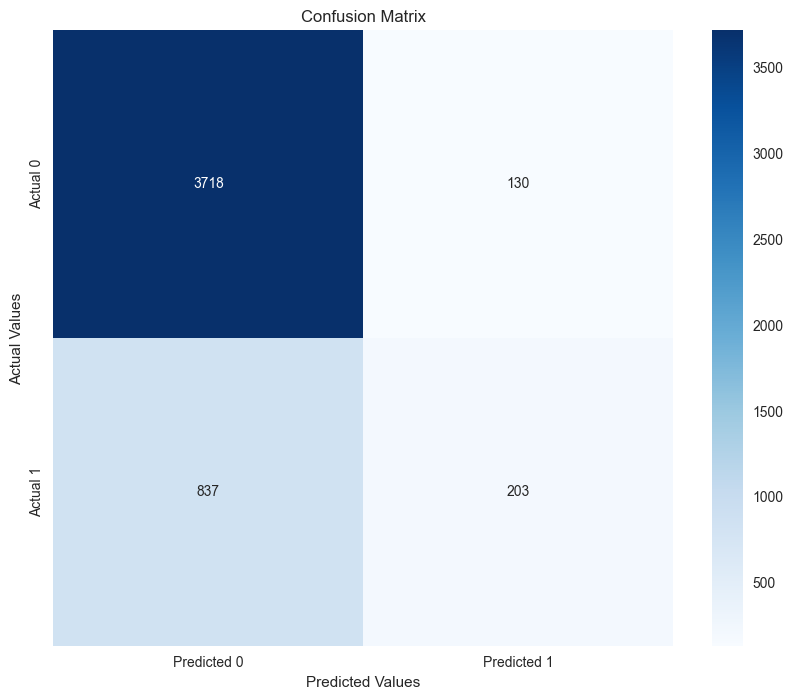


Model Metrics:
Accuracy: 0.802
Precision: 0.610
Recall: 0.195
F1 Score: 0.296


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, let's extract the counts from your prediction type distribution
true_negatives = 3718  # From your distribution
false_negatives = 837
true_positives = 203
false_positives = 130

# Create the confusion matrix array
conf_matrix = np.array([
    [true_negatives, false_positives],
    [false_negatives, true_positives]
])

# Create a more visually appealing display
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# You can also calculate some important metrics
total_predictions = conf_matrix.sum()
accuracy = (true_positives + true_negatives) / total_predictions
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nModel Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}")